In [1]:
!pip install wfdb numpy pandas scikit-learn tensorflow matplotlib
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
# Download MIT-BIH Arrhythmia Database
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/ -P /content/mitdb

# Define records to use
records = ['100', '101', '102']
data = []
labels = []

# Load ECG signals and annotations
for record_name in records:
    record = wfdb.rdrecord(f'/content/mitdb/physionet.org/files/mitdb/1.0.0/{record_name}')
    annotation = wfdb.rdann(f'/content/mitdb/physionet.org/files/mitdb/1.0.0/{record_name}', 'atr')
    signal = record.p_signal[:, 0]  # Use first channel (MLII)
    ann_symbols = annotation.symbol
    ann_samples = annotation.sample

    # Extract 200-sample segments around each heartbeat
    for i, sample in enumerate(ann_samples):
        if sample > 100 and sample < len(signal) - 100:  # Ensure segment fits
            segment = signal[sample-100:sample+100]
            if len(segment) == 200:  # Ensure fixed length
                data.append(segment)
                labels.append(ann_symbols[i])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Print shapes and unique labels to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")

--2025-07-23 13:56:48--  https://physionet.org/files/mitdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/mitdb/physionet.org/files/mitdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  22.87K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2025-07-23 13:56:48 (1.71 MB/s) - ‘/content/mitdb/physionet.org/files/mitdb/1.0.0/index.html’ saved [23416]

Loading robots.txt; please ignore errors.
--2025-07-23 13:56:48--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2025-07-23 13:56:48--  https://physionet.org/files/mitdb/1.0.0/mitdbdir/
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting

In [4]:
# Simplify labels: 'N' (normal) as 0, others (abnormal) as 1
binary_labels = np.where(labels == 'N', 0, 1)

# Normalize the ECG signals
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Reshape data for CNN (samples, length, channels)
data_normalized = data_normalized.reshape(data_normalized.shape[0], data_normalized.shape[1], 1)

# Split into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(data_normalized, binary_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes to verify
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels distribution: {np.bincount(y_train)}")

Training data shape: (4433, 200, 1)
Validation data shape: (950, 200, 1)
Test data shape: (951, 200, 1)
Training labels distribution: [2920 1513]


In [5]:
def build_teacher_model():
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(200, 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(256, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the teacher model
teacher_model = build_teacher_model()
teacher_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 196, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 94, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,753,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,959,105 (11.29 MB)

 Trainable params: 2,959,105 (11.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9469 - loss: 0.1910 - val_accuracy: 0.9926 - val_loss: 0.0292
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9914 - loss: 0.0394 - val_accuracy: 0.9905 - val_loss: 0.0533
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.9930 - loss: 0.0292 - val_accuracy: 0.9947 - val_loss: 0.0225
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9951 - loss: 0.0172 - val_accuracy: 0.9937 - val_loss: 0.0283
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9939 - loss: 0.0171 - val_accuracy: 0.9947 - val_loss: 0.0184
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9922 - loss: 0.0356 - val_accuracy: 0.9958 - val_loss: 0.0108
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9955 - loss: 0.0345 - val_accuracy: 0.9926 - val_loss: 0.0393
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9938 - loss: 0

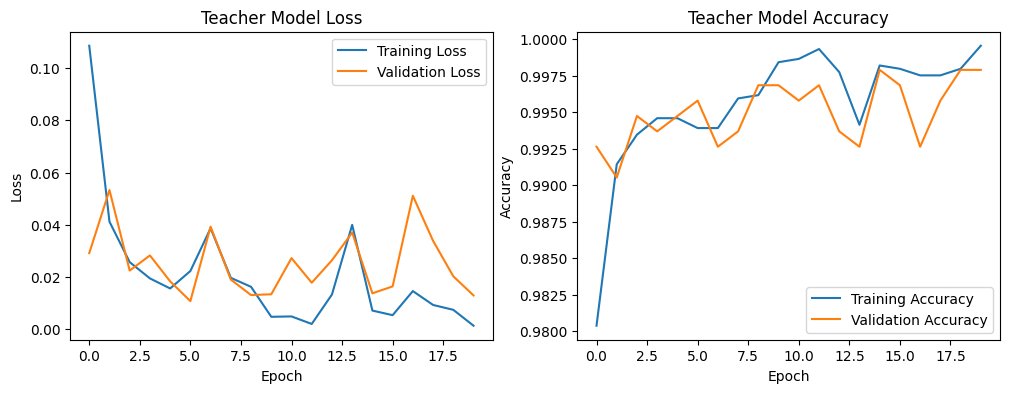

In [6]:
# Train the teacher model
history = teacher_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Teacher Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Teacher Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
def build_student_model():
    model = models.Sequential([
        layers.Conv1D(16, kernel_size=5, activation='relu', input_shape=(200, 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(32, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build and summarize the student model
student_model = build_student_model()
student_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 196, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 98, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 94, 32)         │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1504)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        96,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9577 - loss: 0.4415 - val_accuracy: 0.9914 - val_loss: 0.3655
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9931 - loss: 0.3653 - val_accuracy: 0.9935 - val_loss: 0.3599
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9940 - loss: 0.3601 - val_accuracy: 0.9957 - val_loss: 0.3567
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9920 - loss: 0.3622 - val_accuracy: 0.9946 - val_loss: 0.3566
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9926 - loss: 0.3609 - val_accuracy: 0.9935 - val_loss: 0.3570
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9943 - loss: 0.3580 - val_accuracy: 0.9946 - val_loss: 0.3564
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9962 - loss: 0.3561 - val_accuracy: 0.9957 - val_loss: 0.3547
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9963 - loss: 0.3552 - val_acc

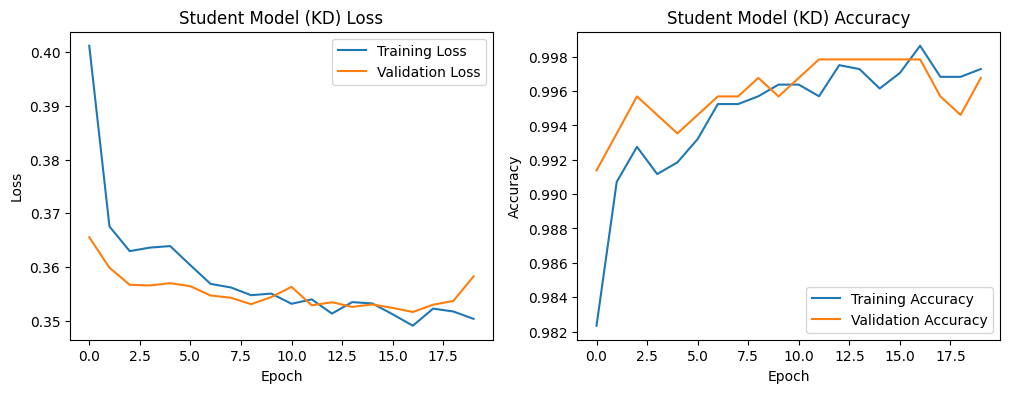

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define KD loss function
def distillation_loss(y_true, y_pred, teacher_model, x, temperature=5.0, alpha=0.5):
    # Reshape y_true to match y_pred's shape (None, 1)
    y_true = tf.reshape(y_true, [-1, 1])

    # Get teacher predictions (logits before sigmoid)
    teacher_logits = teacher_model(x, training=False)

    # Compute soft labels and soft predictions
    soft_labels = tf.nn.sigmoid(teacher_logits / temperature)
    soft_pred = tf.nn.sigmoid(y_pred / temperature)

    # Distillation loss (between soft labels and soft predictions)
    distillation_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(soft_labels, soft_pred))

    # Standard loss (between true labels and student predictions)
    standard_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Combine losses
    return alpha * distillation_loss + (1 - alpha) * standard_loss

# Wrapper function to pass teacher model and inputs
def get_distillation_loss(teacher_model, temperature=5.0, alpha=0.5):
    def loss_fn(y_true, y_pred, x):
        return distillation_loss(y_true, y_pred, teacher_model, x, temperature, alpha)
    return loss_fn

# Prepare datasets with drop_remainder=True to ensure consistent batch sizes
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size, drop_remainder=True)

# Build and compile student model
student_model = build_student_model()
student_model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: get_distillation_loss(teacher_model)(y_true, y_pred, X_train[:batch_size]),
    metrics=['accuracy']
)

# Train the student with KD
history_kd = student_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_kd.history['loss'], label='Training Loss')
plt.plot(history_kd.history['val_loss'], label='Validation Loss')
plt.title('Student Model (KD) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_kd.history['accuracy'], label='Training Accuracy')
plt.plot(history_kd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Student Model (KD) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Evaluate teacher model
teacher_pred = (teacher_model.predict(X_test) > 0.5).astype(int)
print("Teacher Model Evaluation:")
print(classification_report(y_test, teacher_pred, target_names=['Normal', 'Abnormal']))

# Evaluate student model
student_pred = (student_model.predict(X_test) > 0.5).astype(int)
print("Student Model (KD) Evaluation:")
print(classification_report(y_test, student_pred, target_names=['Normal', 'Abnormal']))

# Compare model sizes
teacher_params = teacher_model.count_params()
student_params = student_model.count_params()
print(f"Teacher model parameters: {teacher_params}")
print(f"Student model parameters: {student_params}")
print(f"Parameter reduction: {((teacher_params - student_params) / teacher_params) * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Teacher Model Evaluation:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       650
    Abnormal       0.99      0.99      0.99       301

    accuracy                           0.99       951
   macro avg       0.99      0.99      0.99       951
weighted avg       0.99      0.99      0.99       951

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Student Model (KD) Evaluation:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       650
    Abnormal       1.00      0.98      0.99       301

    accuracy                           0.99       951
   macro avg       0.99      0.99      0.99       951
weighted avg       0.99      0.99      0.99       951

Teacher model parameters: 2959105
Student model parameters: 99073
Parameter reduction: 96.65%


In [10]:
# Save models
teacher_model.save('/content/teacher_model.h5')
student_model.save('/content/student_model.h5')

# Save classification reports
with open('/content/classification_report.txt', 'w') as f:
    f.write("Teacher Model Evaluation:\n")
    f.write(classification_report(y_test, teacher_pred, target_names=['Normal', 'Abnormal']))
    f.write("\nStudent Model (KD) Evaluation:\n")
    f.write(classification_report(y_test, student_pred, target_names=['Normal', 'Abnormal']))
    f.write(f"\nTeacher model parameters: {teacher_params}\n")
    f.write(f"Student model parameters: {student_params}\n")
    f.write(f"Parameter reduction: {((teacher_params - student_params) / teacher_params) * 100:.2f}%")


# Download files
from google.colab import files
files.download('/content/teacher_model.h5')
files.download('/content/student_model.h5')
files.download('/content/classification_report.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>